In [1]:
# Cell 1 - Install & imports
!pip install -q scikit-learn matplotlib seaborn joblib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, classification_report
)
from sklearn.model_selection import GridSearchCV, train_test_split
from tensorflow.keras.datasets import mnist
import random

# reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


In [2]:
# Cell 2 - Parameters (change these if you want other digits or sizes)
digit_a = 0        # first class
digit_b = 1        # second class
total_train_samples = 1000   # total training examples requested
test_samples = 200            # hold-out test set size
# balanced: half digit_a and half digit_b in train and in test


In [3]:
# Cell 3 - Load MNIST and filter chosen digits
(x_train_full, y_train_full), (x_test_full, y_test_full) = mnist.load_data()
X_all = np.concatenate([x_train_full, x_test_full], axis=0)
y_all = np.concatenate([y_train_full, y_test_full], axis=0)

idx_a = np.where(y_all == digit_a)[0]
idx_b = np.where(y_all == digit_b)[0]
print(f"Found {len(idx_a)} examples of {digit_a} and {len(idx_b)} examples of {digit_b}.")


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 6903 examples of 0 and 7877 examples of 1.


In [4]:
# Cell 4 - Sample balanced dataset and create train/test
train_per_class = total_train_samples // 2
test_per_class = test_samples // 2

if train_per_class + test_per_class > min(len(idx_a), len(idx_b)):
    raise ValueError("Not enough samples of one digit to satisfy requested sizes. Lower sizes or choose different digits.")

# choose indices without replacement
chosen_a = np.random.choice(idx_a, train_per_class + test_per_class, replace=False)
chosen_b = np.random.choice(idx_b, train_per_class + test_per_class, replace=False)

chosen_a_train = chosen_a[:train_per_class]
chosen_a_test  = chosen_a[train_per_class: train_per_class + test_per_class]
chosen_b_train = chosen_b[:train_per_class]
chosen_b_test  = chosen_b[train_per_class: train_per_class + test_per_class]

train_idx = np.concatenate([chosen_a_train, chosen_b_train])
test_idx  = np.concatenate([chosen_a_test, chosen_b_test])

X_train = X_all[train_idx]
y_train = y_all[train_idx]
X_test  = X_all[test_idx]
y_test  = y_all[test_idx]

# shuffle
perm_train = np.random.permutation(len(X_train))
perm_test  = np.random.permutation(len(X_test))
X_train, y_train = X_train[perm_train], y_train[perm_train]
X_test, y_test   = X_test[perm_test], y_test[perm_test]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class counts:", np.bincount(y_train.astype(int)))
print("Test  class counts:", np.bincount(y_test.astype(int)))


Train shape: (1000, 28, 28) Test shape: (200, 28, 28)
Train class counts: [500 500]
Test  class counts: [100 100]


In [5]:
# Cell 5 - Preprocess: flatten images and scale
X_train_flat = X_train.reshape((X_train.shape[0], -1)).astype("float32")
X_test_flat  = X_test.reshape((X_test.shape[0], -1)).astype("float32")

# Standardize features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled  = scaler.transform(X_test_flat)

# Map labels to 0/1
label_map = {digit_a: 0, digit_b: 1}
y_train_bin = np.array([label_map[int(v)] for v in y_train])
y_test_bin  = np.array([label_map[int(v)] for v in y_test])

print("Shapes after flatten & scaling:", X_train_scaled.shape, X_test_scaled.shape)


Shapes after flatten & scaling: (1000, 784) (200, 784)


In [6]:
# Cell 6 - Linear SVM (using LinearSVC) - fast baseline
# Note: LinearSVC does not support predict_proba. We will use decision_function for ROC.
from sklearn.svm import LinearSVC
lin_svc = LinearSVC(C=1.0, max_iter=10000, random_state=SEED)
lin_svc.fit(X_train_scaled, y_train_bin)

y_pred_lin = lin_svc.predict(X_test_scaled)
y_score_lin = lin_svc.decision_function(X_test_scaled)  # used for ROC


In [7]:
# Cell 7 - Kernel SVM (RBF) with small GridSearch for C and gamma
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001]
}
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
grid = GridSearchCV(svc_rbf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train_scaled, y_train_bin)

print("Best RBF params:", grid.best_params_)
best_rbf = grid.best_estimator_

y_pred_rbf = best_rbf.predict(X_test_scaled)
y_proba_rbf = best_rbf.predict_proba(X_test_scaled)[:,1]


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best RBF params: {'C': 10, 'gamma': 0.001}


In [8]:
# Cell 8 - Metrics function & compute metrics
def compute_metrics(y_true, y_pred, y_score=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    if y_score is not None:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_score = auc(fpr, tpr)
    else:
        fpr, tpr, auc_score = None, None, None
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'fpr': fpr, 'tpr': tpr, 'auc': auc_score}

metrics_lin = compute_metrics(y_test_bin, y_pred_lin, y_score_lin)
metrics_rbf = compute_metrics(y_test_bin, y_pred_rbf, y_proba_rbf)

print("Linear SVM metrics:")
for k,v in metrics_lin.items():
    if k in ['fpr','tpr']: continue
    print(f"  {k}: {v:.4f}" if v is not None else f"  {k}: None")
print("\nRBF SVM metrics:")
for k,v in metrics_rbf.items():
    if k in ['fpr','tpr']: continue
    print(f"  {k}: {v:.4f}" if v is not None else f"  {k}: None")

print("\nClassification report (RBF):\n", classification_report(y_test_bin, y_pred_rbf, target_names=[str(digit_a), str(digit_b)]))


Linear SVM metrics:
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1: 1.0000
  auc: 1.0000

RBF SVM metrics:
  accuracy: 0.9950
  precision: 1.0000
  recall: 0.9900
  f1: 0.9950
  auc: 0.9999

Classification report (RBF):
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       100
           1       1.00      0.99      0.99       100

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



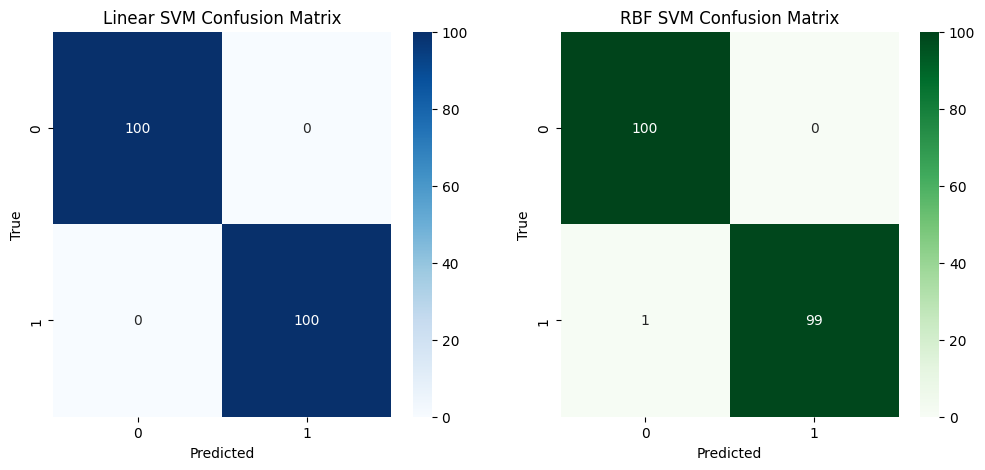

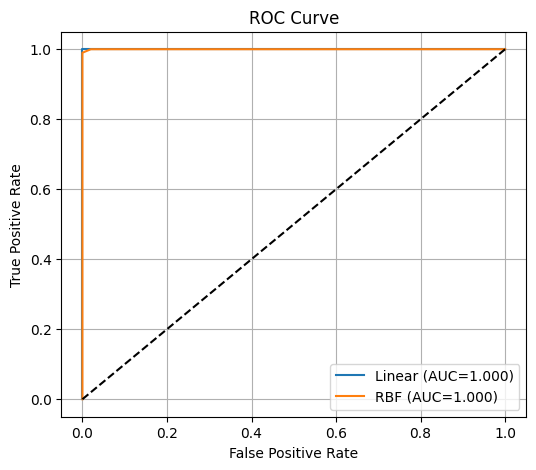

In [9]:
# Cell 9 - Confusion matrices and ROC curves
cm_lin = confusion_matrix(y_test_bin, y_pred_lin)
cm_rbf = confusion_matrix(y_test_bin, y_pred_rbf)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(cm_lin, annot=True, fmt='d', cmap='Blues')
plt.title('Linear SVM Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')

plt.subplot(1,2,2)
sns.heatmap(cm_rbf, annot=True, fmt='d', cmap='Greens')
plt.title('RBF SVM Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

# ROC
plt.figure(figsize=(6,5))
if metrics_lin['fpr'] is not None:
    plt.plot(metrics_lin['fpr'], metrics_lin['tpr'], label=f'Linear (AUC={metrics_lin["auc"]:.3f})')
plt.plot(metrics_rbf['fpr'], metrics_rbf['tpr'], label=f'RBF (AUC={metrics_rbf["auc"]:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(); plt.grid(True)
plt.show()


Total misclassified by RBF: 1


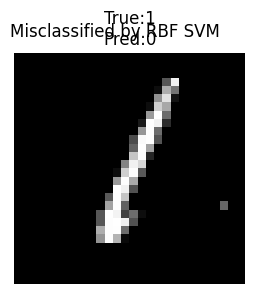

In [10]:
# Cell 10 - Visualize some misclassified images by RBF SVM
mis_idx = np.where(y_pred_rbf != y_test_bin)[0]
print("Total misclassified by RBF:", len(mis_idx))
n_show = min(10, len(mis_idx))
plt.figure(figsize=(12,3))
for i in range(n_show):
    idx = mis_idx[i]
    plt.subplot(1, n_show, i+1)
    plt.imshow(X_test[idx], cmap='gray')
    plt.title(f"True:{y_test_bin[idx]}\nPred:{y_pred_rbf[idx]}")
    plt.axis('off')
plt.suptitle("Misclassified by RBF SVM")
plt.show()


In [11]:
# Cell 11 - Save models and scaler
joblib.dump(scaler, "svm_scaler.joblib")
joblib.dump(lin_svc, "linear_svm.joblib")
joblib.dump(best_rbf, "rbf_svm.joblib")
print("Saved scaler and models: svm_scaler.joblib, linear_svm.joblib, rbf_svm.joblib")


Saved scaler and models: svm_scaler.joblib, linear_svm.joblib, rbf_svm.joblib


In [12]:
# Cell 12 - Summary table for easy comparison
import pandas as pd
results = pd.DataFrame({
    'Model': ['Linear SVM', 'RBF SVM'],
    'Accuracy': [metrics_lin['accuracy'], metrics_rbf['accuracy']],
    'Precision': [metrics_lin['precision'], metrics_rbf['precision']],
    'Recall': [metrics_lin['recall'], metrics_rbf['recall']],
    'F1': [metrics_lin['f1'], metrics_rbf['f1']],
    'AUC': [metrics_lin['auc'], metrics_rbf['auc']]
})
display(results)


,Model,Accuracy,Precision,Recall,F1,AUC
0,Linear SVM,1.000,1.0,1.00,1.000000,1.0000
1,RBF SVM,0.995,1.0,0.99,0.994975,0.9999


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Recall'].plot(kind='hist', bins=20, title='Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['F1'].plot(kind='hist', bins=20, title='F1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='index', y='Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Accuracy', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Recall', y='F1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='F1', y='AUC', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Recall']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Recall')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['F1']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('F1')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['AUC']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('AUC')

from matplotlib import pyplot as plt
_df_13['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Recall'].plot(kind='line', figsize=(8, 4), title='Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['F1'].plot(kind='line', figsize=(8, 4), title='F1')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='index', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='Recall', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='F1', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

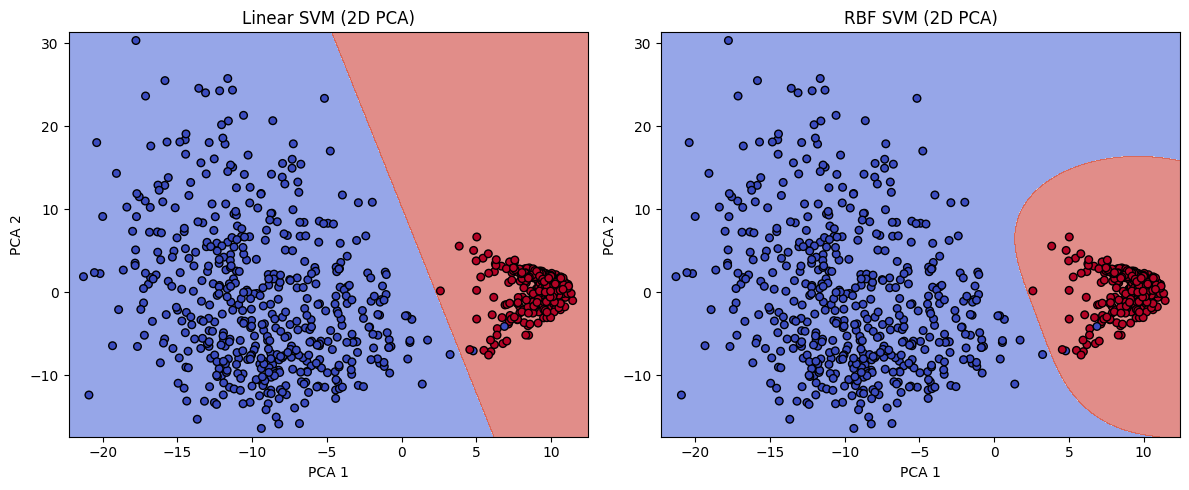

In [13]:
# Cell 13 — PCA + Decision Boundary Visualization
from sklearn.decomposition import PCA

# Reduce data to 2D for visualization only
pca = PCA(n_components=2, random_state=SEED)
X_train_2d = pca.fit_transform(X_train_scaled)
X_test_2d = pca.transform(X_test_scaled)

# Retrain simple SVMs on 2D for visualization clarity
svc_lin_2d = SVC(kernel='linear').fit(X_train_2d, y_train_bin)
svc_rbf_2d = SVC(kernel='rbf', gamma='scale').fit(X_train_2d, y_train_bin)

# Plot helper
def plot_decision_boundary(model, X, y, title):
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', s=30)
    plt.title(title)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_decision_boundary(svc_lin_2d, X_train_2d, y_train_bin, "Linear SVM (2D PCA)")
plt.subplot(1,2,2)
plot_decision_boundary(svc_rbf_2d, X_train_2d, y_train_bin, "RBF SVM (2D PCA)")
plt.tight_layout()
plt.show()


In [14]:
# Cell 14 — Compare support vectors and runtime
print("Linear SVM support vectors (approximation): not directly available in LinearSVC.")
print("RBF SVM support vectors count:", len(best_rbf.support_))

# To visualize distribution of support vectors per class:
sv_labels = y_train_bin[best_rbf.support_]
unique, counts = np.unique(sv_labels, return_counts=True)
print("Support vectors per class:", dict(zip(unique, counts)))


Linear SVM support vectors (approximation): not directly available in LinearSVC.
RBF SVM support vectors count: 108
Support vectors per class: {np.int64(0): np.int64(69), np.int64(1): np.int64(39)}


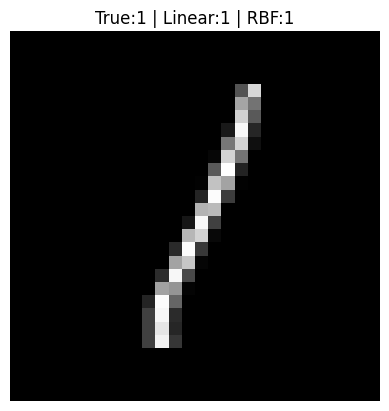

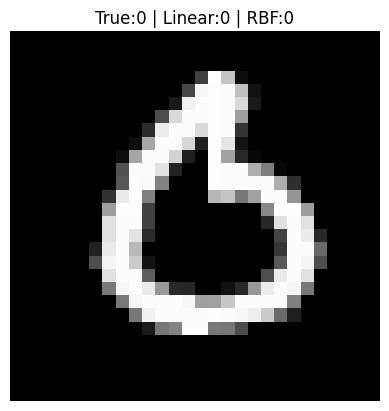

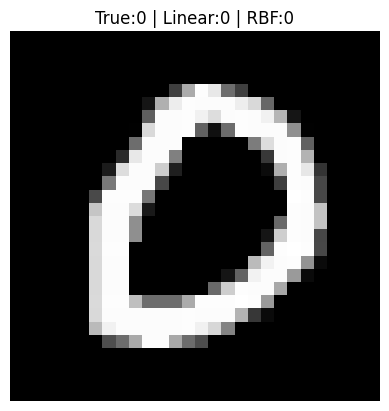

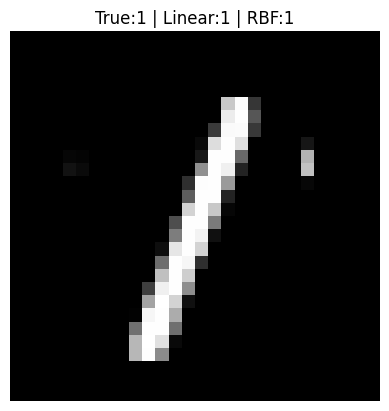

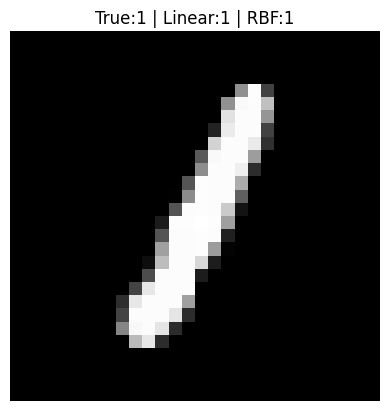

In [15]:
# Cell 15 — Random test image predictions by both SVMs
for _ in range(5):
    idx = np.random.randint(0, len(X_test))
    img = X_test[idx]
    true = y_test_bin[idx]
    lin_pred = lin_svc.predict(X_test_scaled[idx:idx+1])[0]
    rbf_pred = best_rbf.predict(X_test_scaled[idx:idx+1])[0]
    plt.imshow(img, cmap='gray')
    plt.title(f"True:{true} | Linear:{lin_pred} | RBF:{rbf_pred}")
    plt.axis('off')
    plt.show()


In [16]:
# Cell 16 — Save all metrics to a report file
with open("svm_results_summary.txt", "w") as f:
    f.write("=== Linear SVM ===\n")
    for k,v in metrics_lin.items():
        if k not in ['fpr','tpr']:
            f.write(f"{k}: {v}\n")
    f.write("\n=== RBF SVM ===\n")
    for k,v in metrics_rbf.items():
        if k not in ['fpr','tpr']:
            f.write(f"{k}: {v}\n")
    f.write("\nConfusion Matrix (RBF):\n")
    f.write(np.array2string(confusion_matrix(y_test_bin, y_pred_rbf)))
    f.write("\n\nClassification Report (RBF):\n")
    f.write(classification_report(y_test_bin, y_pred_rbf))
print("✅ Saved report to svm_results_summary.txt")


✅ Saved report to svm_results_summary.txt


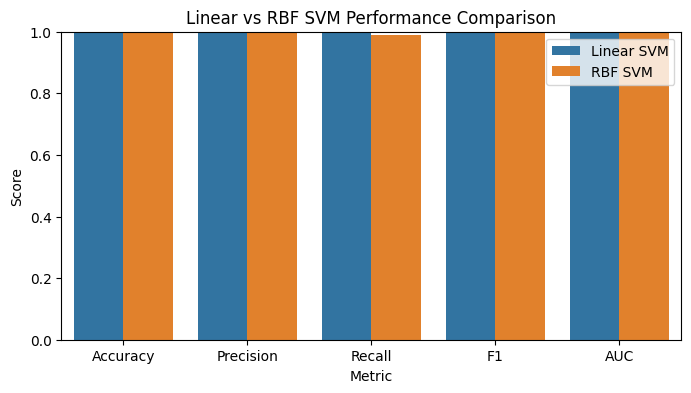

In [17]:
# Cell 17 — Visual comparison bar chart
import pandas as pd
plt.figure(figsize=(8,4))
sns.barplot(
    data=results.melt(id_vars='Model', var_name='Metric', value_name='Score'),
    x='Metric', y='Score', hue='Model'
)
plt.title("Linear vs RBF SVM Performance Comparison")
plt.ylim(0,1)
plt.legend()
plt.show()
